<a href="https://colab.research.google.com/github/DataSnek/ML-Project/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os

# Auto-load all files
# Mounting drive to avoid manual uploads
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# reducing the memory to allow scalable joins and faster experimentation
def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
        else:
            df[col] = df[col].astype('category')
    return df

In [16]:
# Unzipping the data
# We use -n to avoid overwriting if it already exists
if not os.path.exists('/content/dataset'):
    !unzip -n -q "/content/drive/My Drive/Data" -d "/content/dataset"

In [17]:
# Extract variables
print("Loading CSVs...")
orders = pd.read_csv('/content/dataset/orders.csv')
products = pd.read_csv('/content/dataset/products.csv')
departments = pd.read_csv('/content/dataset/departments.csv')
aisles = pd.read_csv('/content/dataset/aisles.csv')
order_products_prior = pd.read_csv('/content/dataset/order_products__prior.csv')
order_products_train = pd.read_csv('/content/dataset/order_products__train.csv')
print("Data loaded.")

Loading CSVs...
Data loaded.


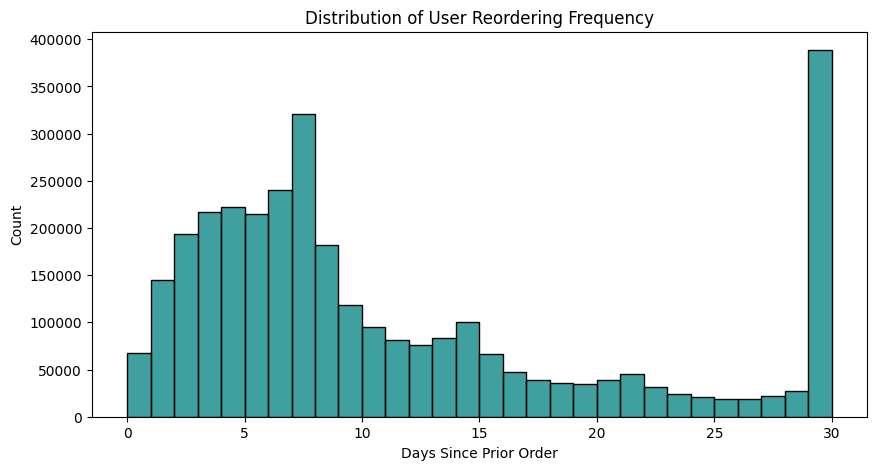

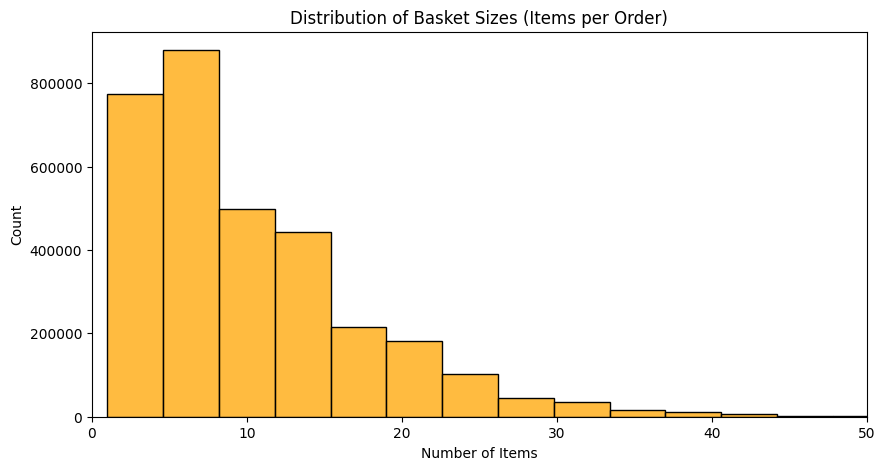

/tmp/ipython-input-3255776874.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_product_names.values, y=order_products_prior['product_id'].value_counts().head(10).values, palette='viridis')


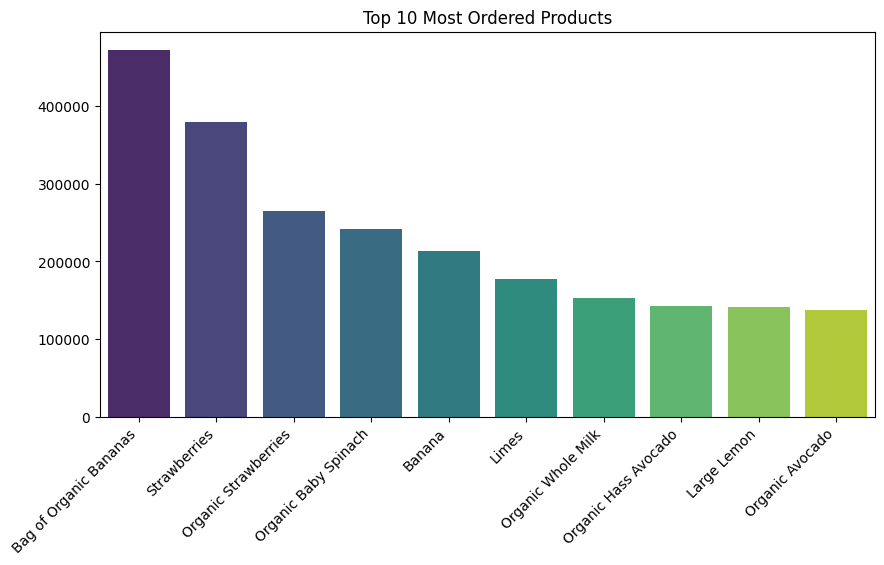

--- Outlier Detection ---
Max items in one order: 145
Max orders by one user: 100


In [18]:

import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of Days Since Prior Order
plt.figure(figsize=(10, 5))
sns.histplot(orders['days_since_prior_order'].dropna(), bins=30, kde=False, color='teal')
plt.title('Distribution of User Reordering Frequency')
plt.xlabel('Days Since Prior Order')
plt.ylabel('Count')
plt.show()

# Basket Size Analysis {Items per Order}
basket_sizes = order_products_prior.groupby('order_id')['product_id'].count()

plt.figure(figsize=(10, 5))
sns.histplot(basket_sizes, bins=40, kde=False, color='orange')
plt.title('Distribution of Basket Sizes (Items per Order)')
plt.xlabel('Number of Items')
plt.xlim(0, 50) # Cap at 50 for readability
plt.show()

# Top 10 Popular Products
top_products = order_products_prior['product_id'].value_counts().head(10).index

top_product_names = products[products['product_id'].isin(top_products)]['product_name']

plt.figure(figsize=(10, 5))
sns.barplot(x=top_product_names.values, y=order_products_prior['product_id'].value_counts().head(10).values, palette='viridis')
plt.title('Top 10 Most Ordered Products')
plt.xticks(rotation=45, ha='right')
plt.show()

#  Outlier Detection
# Check for  bots or massive orders
print("--- Outlier Detection ---")
print(f"Max items in one order: {basket_sizes.max()}")
print(f"Max orders by one user: {orders.groupby('user_id').size().max()}")


In [19]:
# reducing the memory
orders = reduce_mem_usage(orders)
products = reduce_mem_usage(products)
departments = reduce_mem_usage(departments)
aisles = reduce_mem_usage(aisles)
order_products_prior = reduce_mem_usage(order_products_prior)
order_products_train = reduce_mem_usage(order_products_train)
print("Memory reduction complete.")

Memory reduction complete.


In [20]:
# merging the tables
# Merge safely to create the full product info
products_full = (
    products
    .merge(aisles, on="aisle_id", how="left")
    .merge(departments, on="department_id", how="left")
)

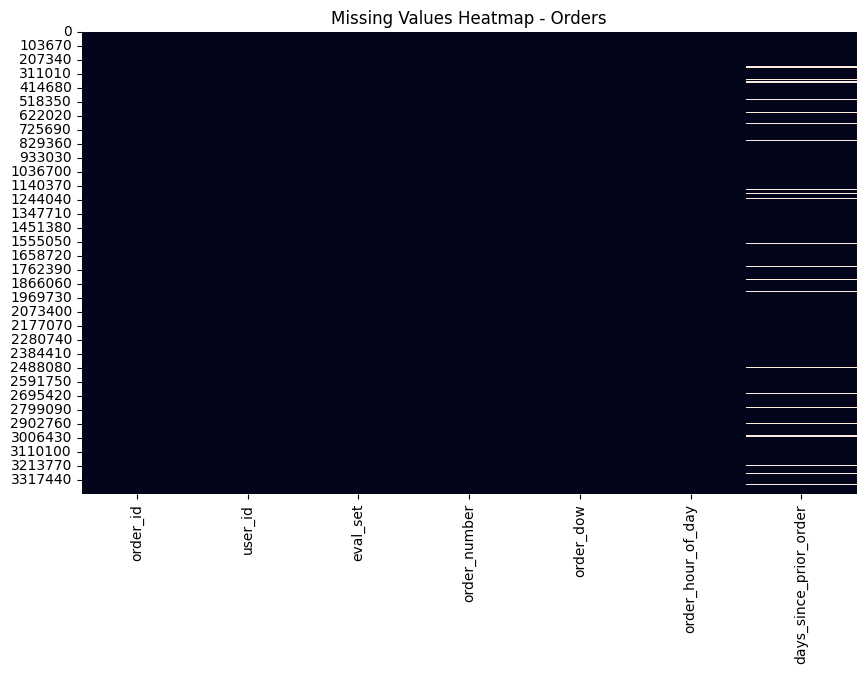

In [21]:
# missing value visulisation
plt.figure(figsize=(10, 6))
sns.heatmap(orders.isnull(), cbar=False)
plt.title("Missing Values Heatmap - Orders")
plt.show()

In [22]:
# Imputation was chosen as NaN indicates the first order for the user (0 days)
orders["days_since_prior_order"] = orders["days_since_prior_order"].fillna(0)

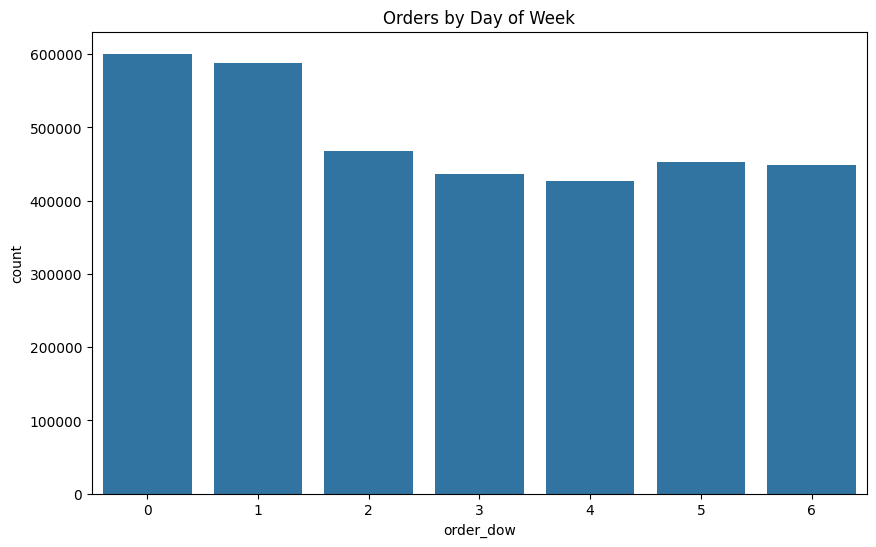

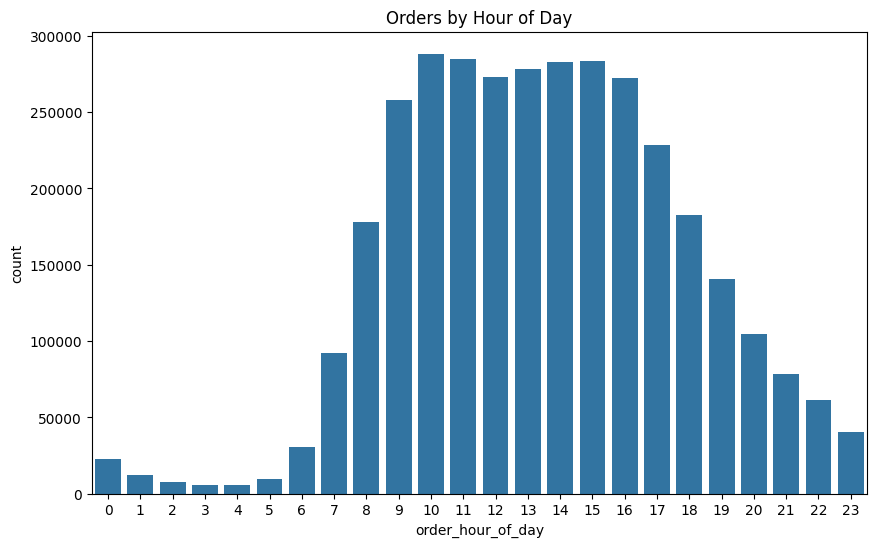

In [23]:
# A Day
plt.figure(figsize=(10, 6))
sns.countplot(x="order_dow", data=orders)
plt.title("Orders by Day of Week")
plt.show()

# hour
plt.figure(figsize=(10, 6))
sns.countplot(x="order_hour_of_day", data=orders)
plt.title("Orders by Hour of Day")
plt.show()

Rows to plot: 10


/tmp/ipython-input-1779202202.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="product_name", x="count", data=top_products, palette='viridis')


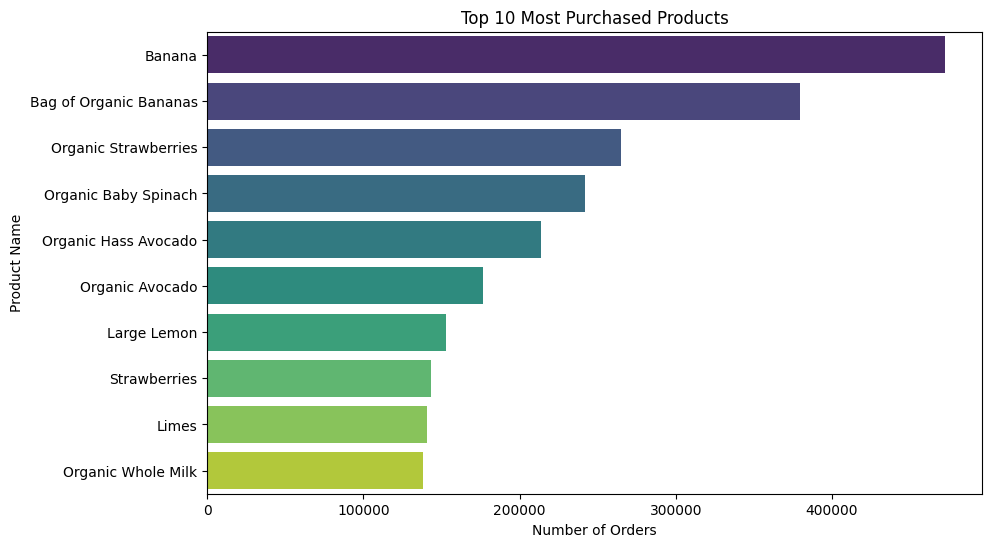

In [24]:
# Calculate the top 10
top_products_counts = order_products_prior["product_id"].value_counts().head(10).reset_index()
top_products_counts.columns = ['product_id', 'count']

# Merge with product names
top_products = top_products_counts.merge(products, on="product_id")

#  Convert 'product_name' from Category to String
# This stops the plot from trying to show hidden categories
top_products['product_name'] = top_products['product_name'].astype(str)

#Sanity Check: Ensure we only have 10 rows
print(f"Rows to plot: {top_products.shape[0]}") # Should say 10
if top_products.shape[0] > 10:
    top_products = top_products.head(10) # Force limit if merge expanded it

#  Plot Cleanly
plt.figure(figsize=(10, 6))
sns.barplot(y="product_name", x="count", data=top_products, palette='viridis')
plt.title("Top 10 Most Purchased Products")
plt.xlabel("Number of Orders")
plt.ylabel("Product Name")
plt.show()

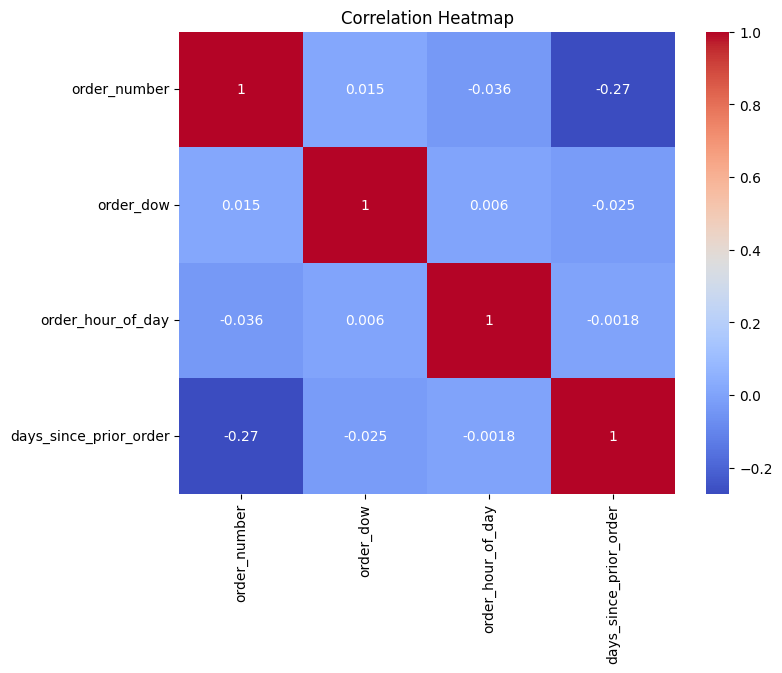

In [25]:
# correlation heatmap
corr_df = orders[["order_number", "order_dow", "order_hour_of_day", "days_since_prior_order"]]
plt.figure(figsize=(8,6))
sns.heatmap(corr_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

Reloading CSVs for EDA...
Data reloaded.
Applying memory reduction...
Memory reduction complete.
COMPREHENSIVE EDA ----- DISTRIBUTION ANALYSIS


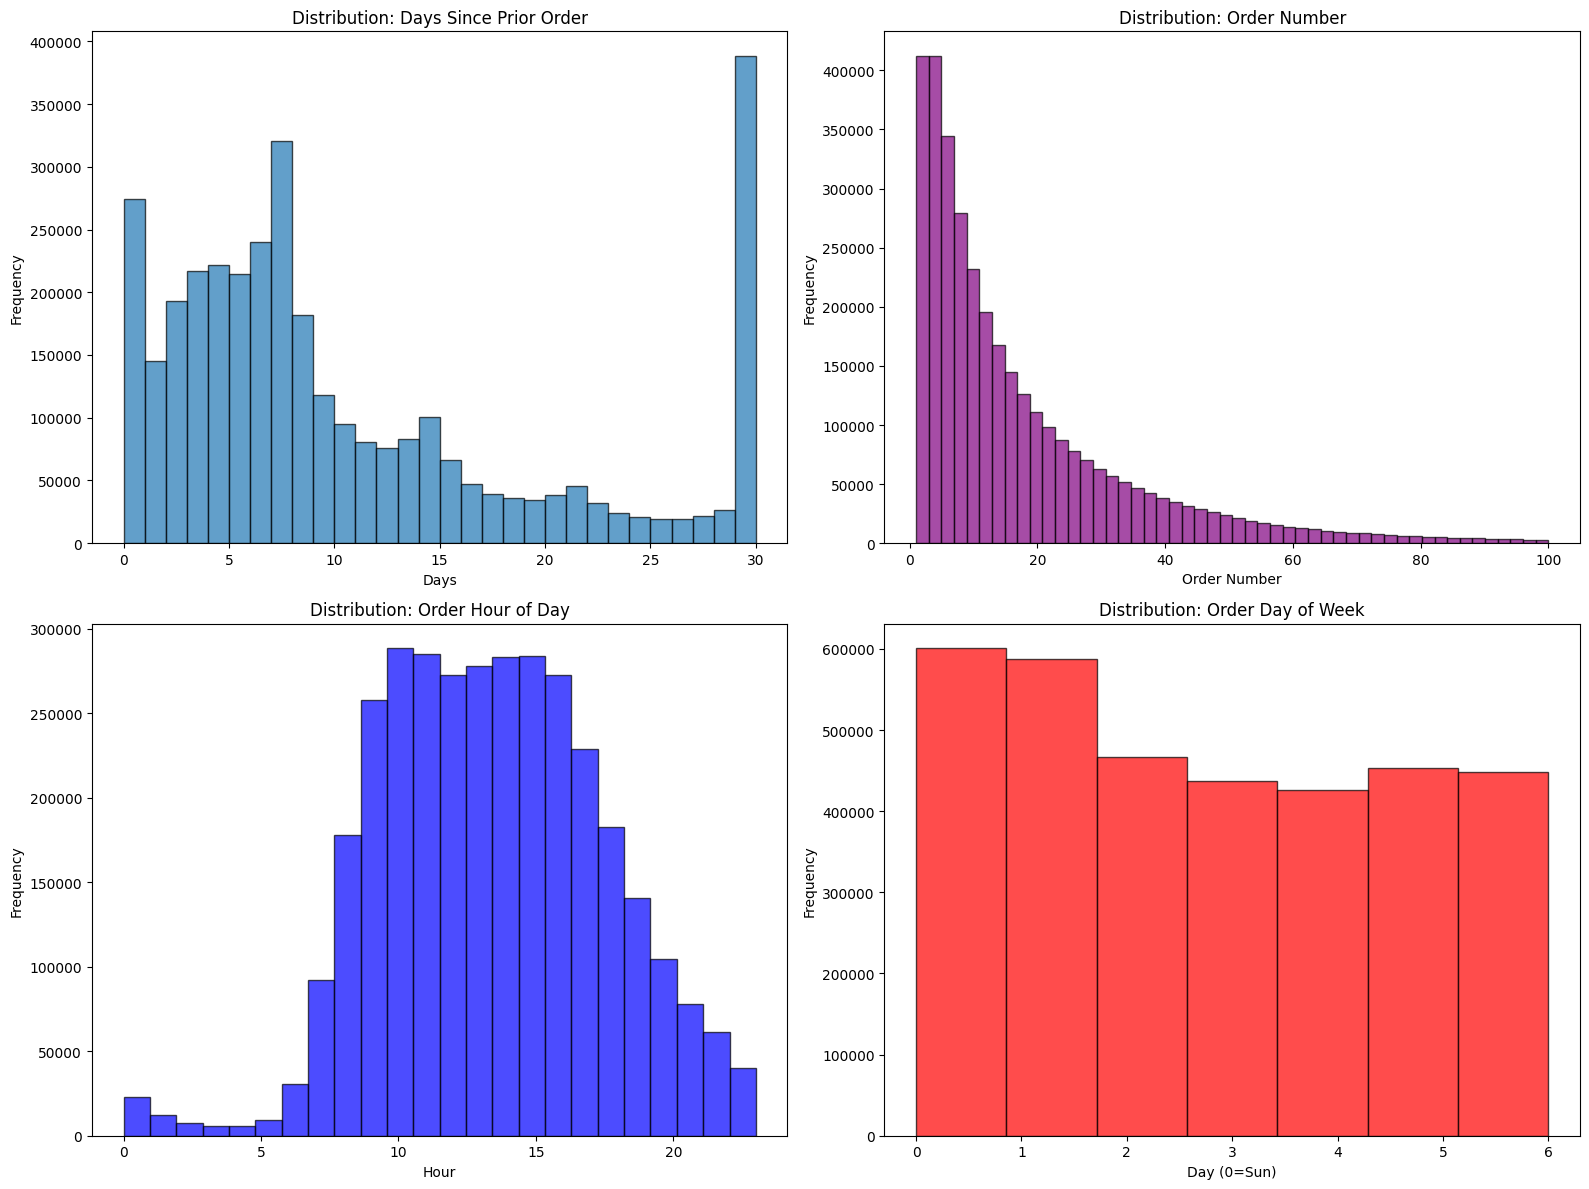

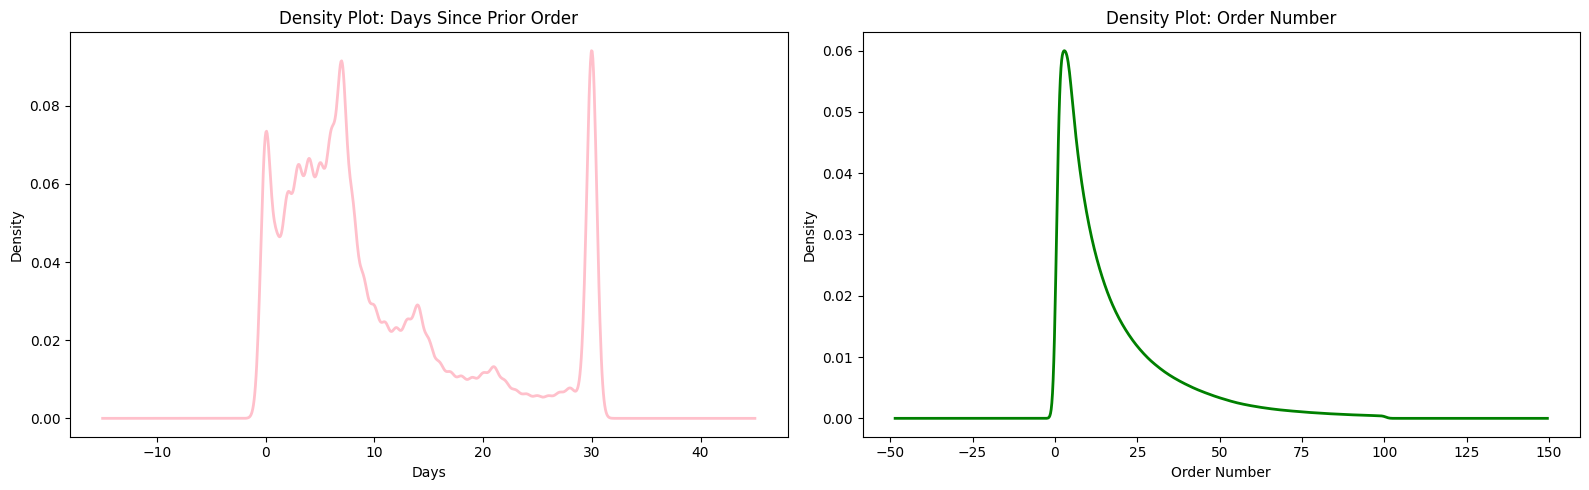


CATEGORICAL CARDINALITY ANALYSIS
Number of unique products: 49688
Number of unique aisles: 134
Number of unique departments: 21
Number of unique users: 206209


/tmp/ipython-input-300153281.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dept_counts.values, y=dept_counts.index, palette='viridis')


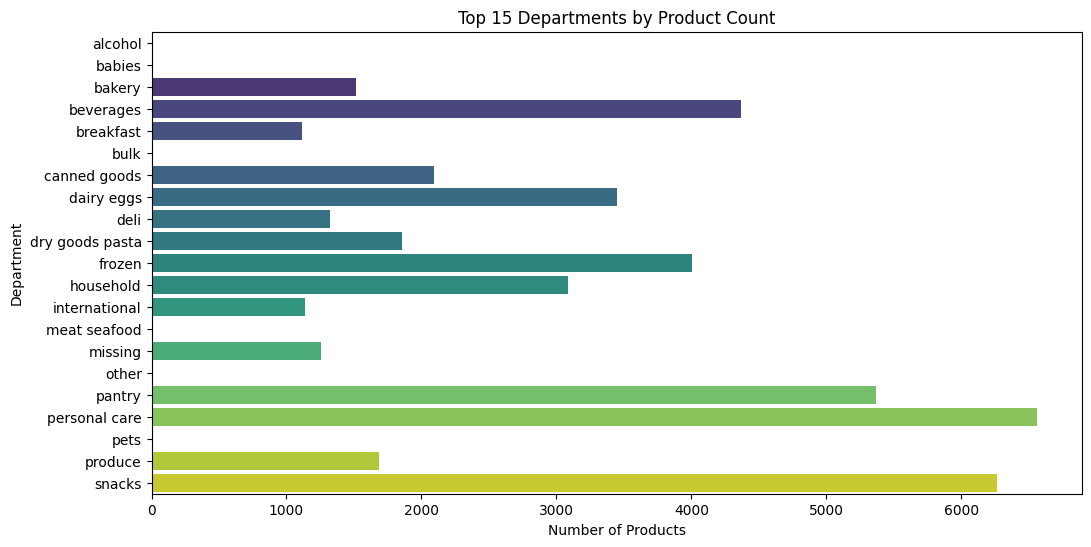

/tmp/ipython-input-300153281.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=aisle_counts.values, y=aisle_counts.index, palette='plasma')


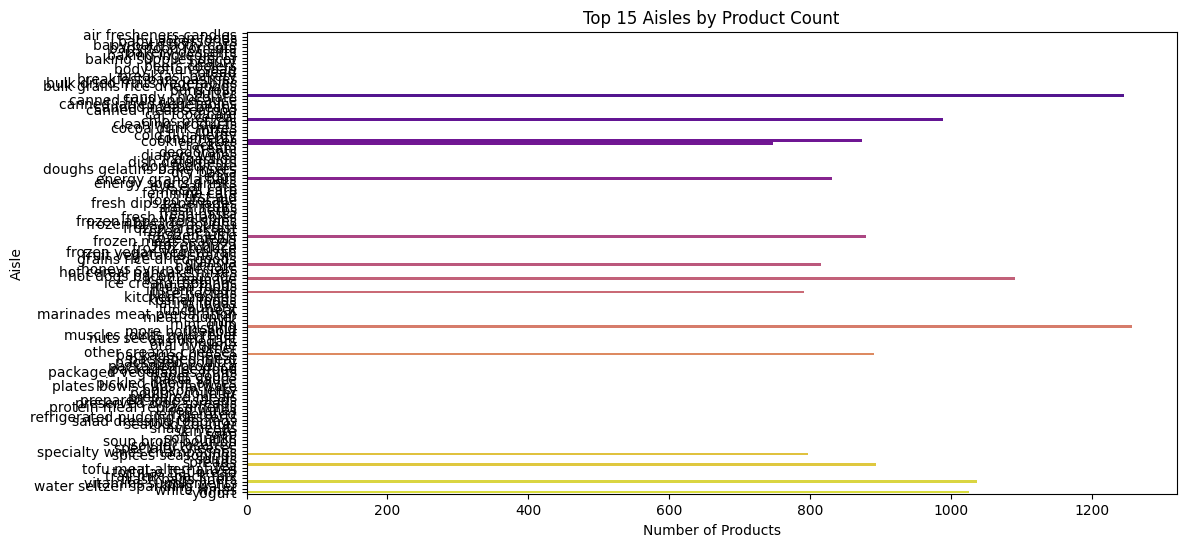


PAIRWISE SCATTER PLOTS


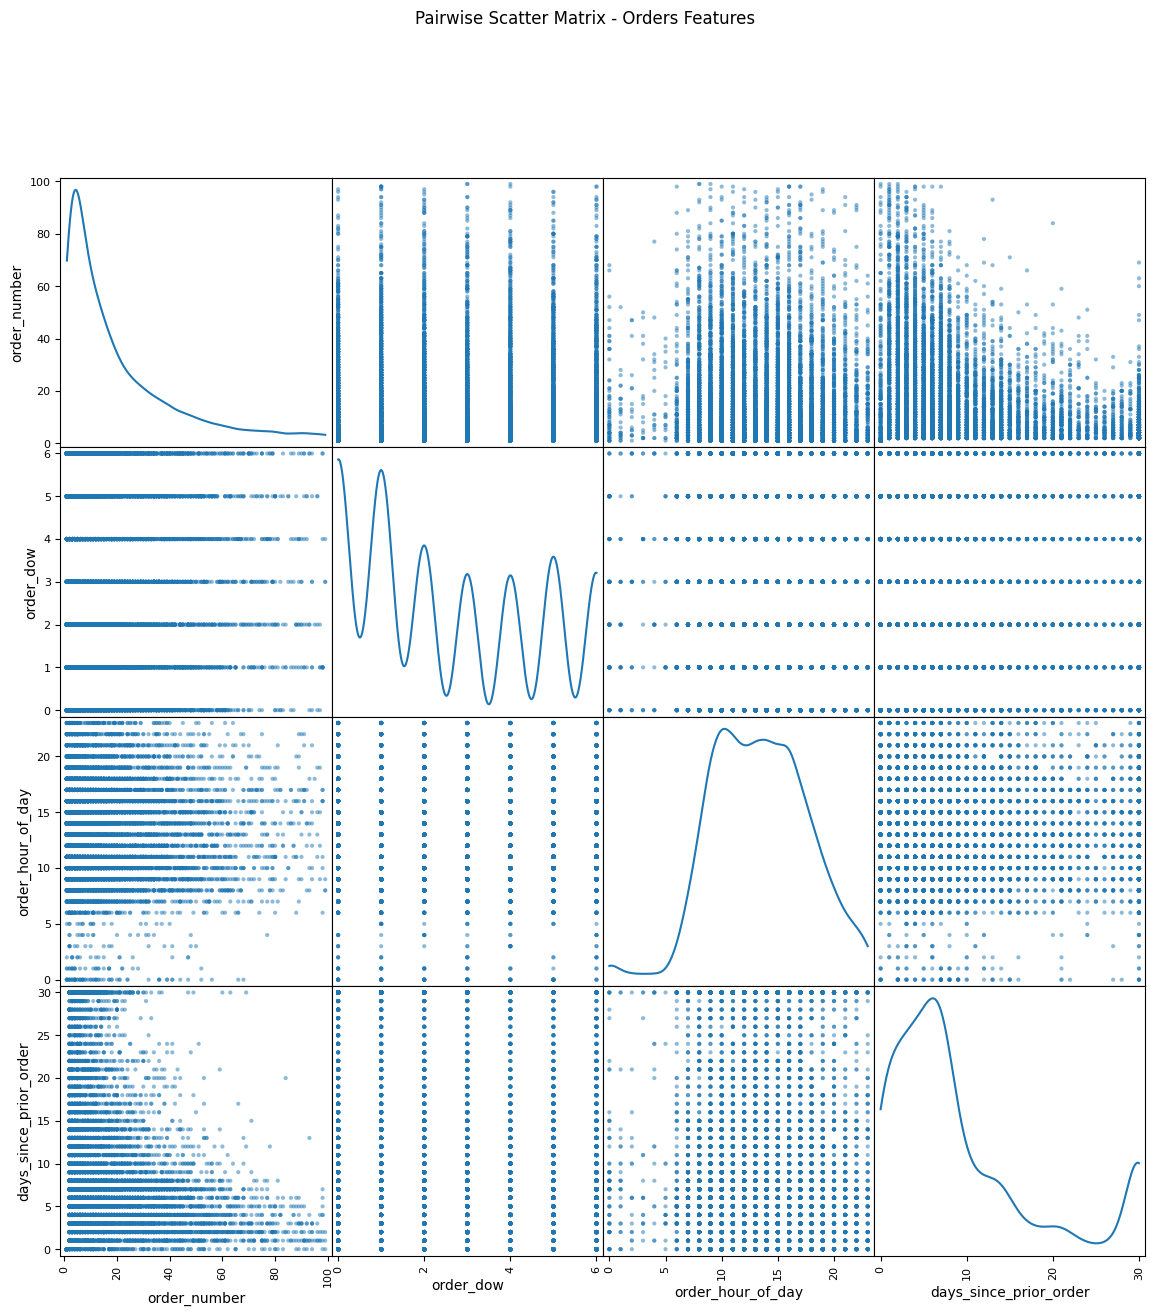


MISSING VALUES ANALYSIS ------ ALL TABLES


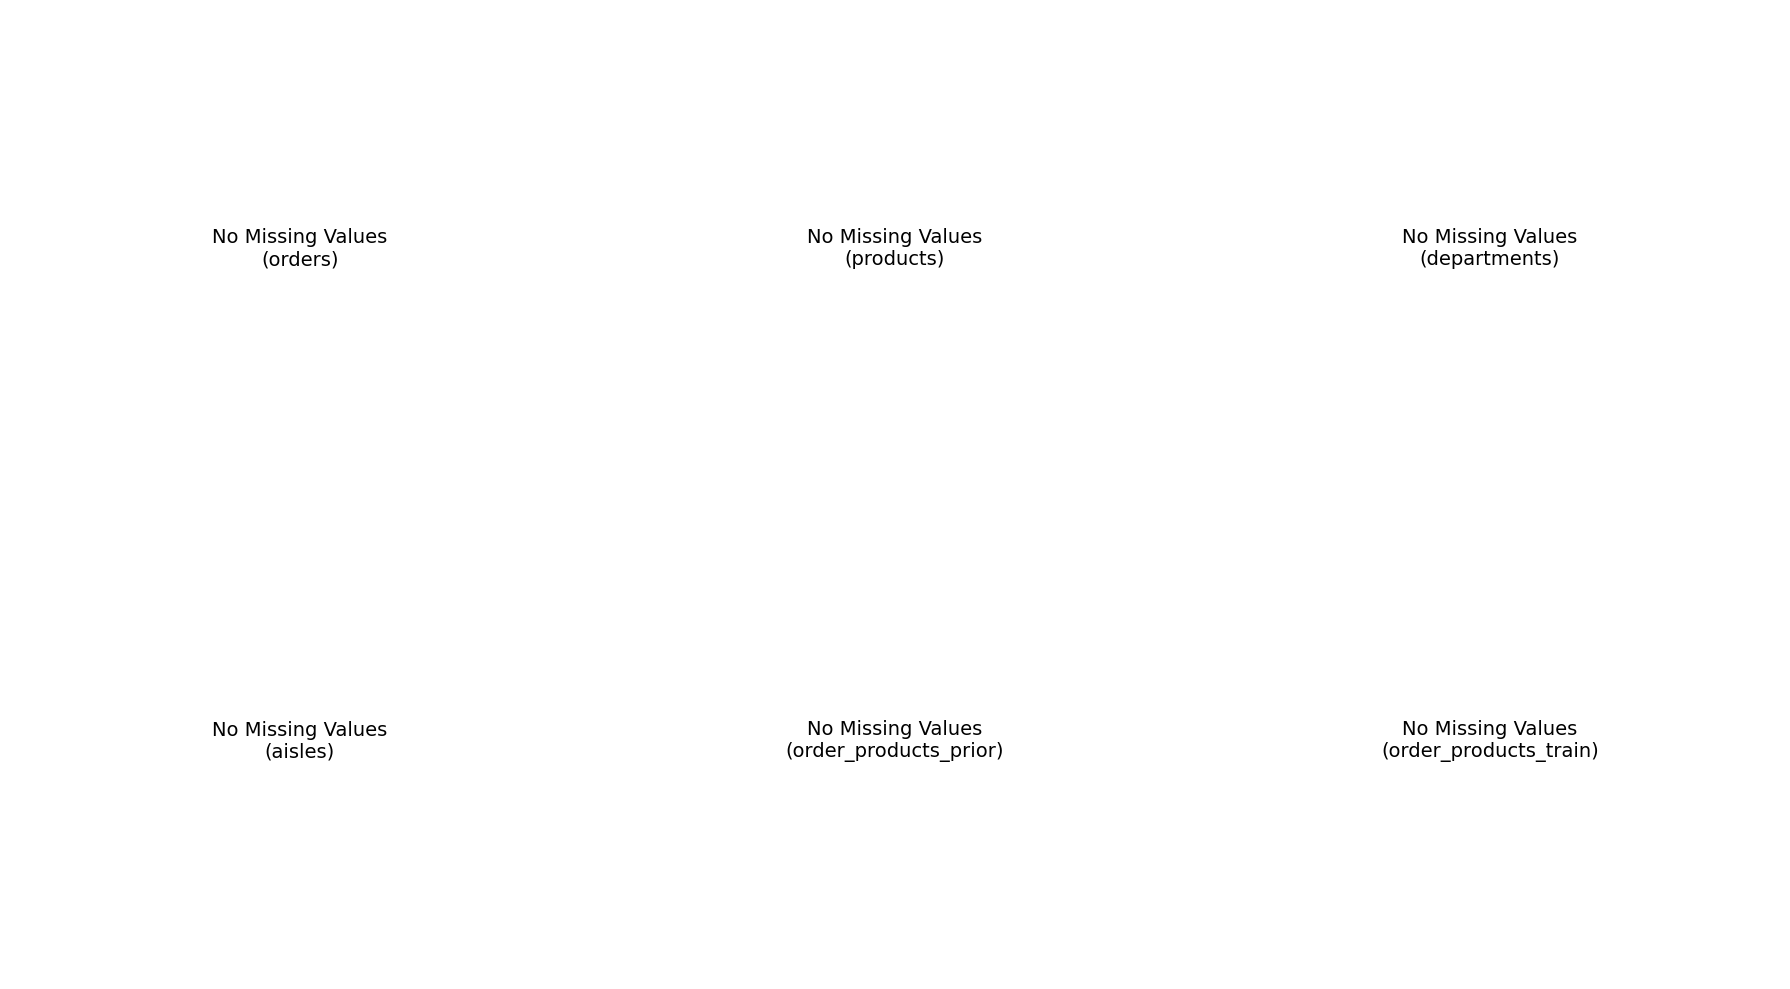

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# reducing the memory to allow scalable joins and faster experimentation
def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
        else:
            df[col] = df[col].astype('category')
    return df

# Reloading dataframes needed for this EDA cell, as they were deleted previously
print("Reloading CSVs for EDA...")
orders = pd.read_csv('/content/dataset/orders.csv')
products = pd.read_csv('/content/dataset/products.csv')
departments = pd.read_csv('/content/dataset/departments.csv')
aisles = pd.read_csv('/content/dataset/aisles.csv')
order_products_prior = pd.read_csv('/content/dataset/order_products__prior.csv')
order_products_train = pd.read_csv('/content/dataset/order_products__train.csv')
print("Data reloaded.")

print("Applying memory reduction...")
orders = reduce_mem_usage(orders)
products = reduce_mem_usage(products)
departments = reduce_mem_usage(departments)
aisles = reduce_mem_usage(aisles)
order_products_prior = reduce_mem_usage(order_products_prior)
order_products_train = reduce_mem_usage(order_products_train)
print("Memory reduction complete.")

# Imputation for days_since_prior_order, as done previously
orders["days_since_prior_order"] = orders["days_since_prior_order"].fillna(0)

# Re-create products_full
products_full = (
    products
    .merge(aisles, on="aisle_id", how="left")
    .merge(departments, on="department_id", how="left")
)

print("="*80)
print("COMPREHENSIVE EDA ----- DISTRIBUTION ANALYSIS")
print("="*80)

# Distribution plots for ALL numeric features in orders
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Days since prior order
axes[0, 0].hist(orders['days_since_prior_order'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution: Days Since Prior Order')
axes[0, 0].set_xlabel('Days')
axes[0, 0].set_ylabel('Frequency')

# Order number
axes[0, 1].hist(orders['order_number'], bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[0, 1].set_title('Distribution: Order Number')
axes[0, 1].set_xlabel('Order Number')
axes[0, 1].set_ylabel('Frequency')

# Hour of day
axes[1, 0].hist(orders['order_hour_of_day'], bins=24, edgecolor='black', alpha=0.7, color='blue')
axes[1, 0].set_title('Distribution: Order Hour of Day')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('Frequency')

# Day of week
axes[1, 1].hist(orders['order_dow'], bins=7, edgecolor='black', alpha=0.7, color='red')
axes[1, 1].set_title('Distribution: Order Day of Week')
axes[1, 1].set_xlabel('Day (0=Sun)')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Density plots with KDE
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

orders['days_since_prior_order'].plot(kind='density', ax=axes[0], color='pink', linewidth=2)
axes[0].set_title('Density Plot: Days Since Prior Order')
axes[0].set_xlabel('Days')

orders['order_number'].plot(kind='density', ax=axes[1], color='green', linewidth=2)
axes[1].set_title('Density Plot: Order Number')
axes[1].set_xlabel('Order Number')

plt.tight_layout()
plt.show()

# Categorical Cardinality Analysis
print("\n" + "="*80)
print("CATEGORICAL CARDINALITY ANALYSIS")
print("="*80)

# Products cardinality
print(f"Number of unique products: {products['product_id'].nunique()}")
print(f"Number of unique aisles: {aisles['aisle_id'].nunique()}")
print(f"Number of unique departments: {departments['department_id'].nunique()}")
print(f"Number of unique users: {orders['user_id'].nunique()}")

# Top 15 departments
dept_counts = products_full['department'].value_counts().head(15)
plt.figure(figsize=(12, 6))
sns.barplot(x=dept_counts.values, y=dept_counts.index, palette='viridis')
plt.title('Top 15 Departments by Product Count')
plt.xlabel('Number of Products')
plt.ylabel('Department')
plt.show()

# Top 15 aisles
aisle_counts = products_full['aisle'].value_counts().head(15)
plt.figure(figsize=(12, 6))
sns.barplot(x=aisle_counts.values, y=aisle_counts.index, palette='plasma')
plt.title('Top 15 Aisles by Product Count')
plt.xlabel('Number of Products')
plt.ylabel('Aisle')
plt.show()

# Pairwise Scatter Plots
print("\n" + "="*80)
print("PAIRWISE SCATTER PLOTS")
print("="*80)

from pandas.plotting import scatter_matrix

# visualization
sample_orders = orders[orders.eval_set == 'prior'].sample(n=10000, random_state=42)
scatter_cols = ['order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']

fig = scatter_matrix(sample_orders[scatter_cols], figsize=(14, 14),
                     diagonal='kde', alpha=0.5, marker='.')
plt.suptitle('Pairwise Scatter Matrix - Orders Features', y=1.0)
plt.show()

#  Missing Values Analysis
print("\n" + "="*80)
print("MISSING VALUES ANALYSIS ------ ALL TABLES")
print("="*80)

tables = {
    'orders': orders,
    'products': products,
    'departments': departments,
    'aisles': aisles,
    'order_products_prior': order_products_prior,
    'order_products_train': order_products_train
}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (name, df) in enumerate(tables.items()):
    missing_pct = (df.isnull().sum() / len(df)) * 100
    if missing_pct.sum() > 0:
        sns.heatmap(df.isnull(), cbar=False, ax=axes[idx], yticklabels=False)
        axes[idx].set_title(f'Missing Values: {name}')
    else:
        axes[idx].text(0.5, 0.5, f'No Missing Values\n({name})',
                      ha='center', va='center', fontsize=14)
        axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Print summary
for name, df in tables.items():
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"\n{name}:")
        print(missing[missing > 0])

In [27]:
def check_data_integrity():
    print("--- Starting Sanity Checks ---\n")

    # CHECK IMPUTATION
    # We expect 0 missing values in days_since_prior_order now
    missing_days = orders['days_since_prior_order'].isnull().sum()
    assert missing_days == 0, f"FAILED: Found {missing_days} nulls in days_since_prior_order!"
    print(f" Imputation Check: PASSED (0 missing values)")

    # CHECK RANGES (Logical Consistency)
    # Days of week must be 0-6
    assert orders['order_dow'].min() >= 0 and orders['order_dow'].max() <= 6, "FAILED: order_dow out of range (0-6)"
    # Hours must be 0-23
    assert orders['order_hour_of_day'].min() >= 0 and orders['order_hour_of_day'].max() <= 23, "FAILED: Hour out of range (0-23)"
    # Days since prior order (max is usually 30 in this dataset)
    assert orders['days_since_prior_order'].max() <= 30, "FAILED: days_since_prior_order > 30 found"
    print(f" Logical Range Check: PASSED")

    #  CHECK MEMORY REDUCTION SAFETY
    # If reduction was too aggressive, IDs might become negative (overflow)
    assert orders['order_id'].min() > 0, "FAILED: Negative order_id found! Memory reduction corrupted data."
    assert products['product_id'].min() > 0, "FAILED: Negative product_id found!"
    print(f" Memory Safety Check: PASSED")

    #  CHECK REFERENTIAL INTEGRITY
    # Do we have products in orders that don't exist in the product table?
    unique_products_ordered = order_products_prior['product_id'].unique()
    unique_products_listed = products['product_id'].unique()
    # Check if all ordered products exist in product list
    # isin returns boolean, all() checks if they are all True
    assert np.isin(unique_products_ordered, unique_products_listed).all(), "FAILED: Found orders for product_ids that don't exist in products table!"
    print(f" Referential Integrity Check: PASSED")

    print("\n--- All Checks Passed. You are ready for Feature Engineering! ---")

check_data_integrity()

--- Starting Sanity Checks ---

 Imputation Check: PASSED (0 missing values)
 Logical Range Check: PASSED
 Memory Safety Check: PASSED
 Referential Integrity Check: PASSED

--- All Checks Passed. You are ready for Feature Engineering! ---
